## Image segmentation using UNET 
![UNET model architecture](https://github.com/DimitrisMitroulis/MyUnet/blob/main/UNET.jpg?raw=1)



### Unet is split into 3 parts
- **Encoder** (Left) where the image is reducing in dimensions but increasing in channels
- **Bottleneck** (middle) where we preforms some convultions
- **Decoder**(right) where we are upsampling using 2dconvolutions the image to it's original size

### Additional techniques:
- Residual(skip) connections. We add part of the data from previous layers to next ones

In each "block" we are preforming these actions

Convulution, batch normalization, relu activation, convolution batch norm then again relu activation

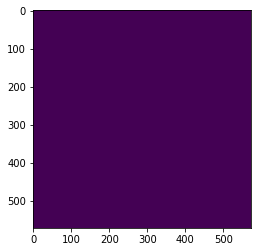

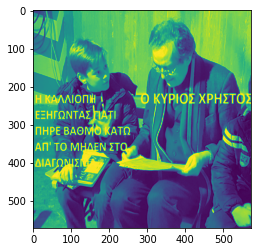

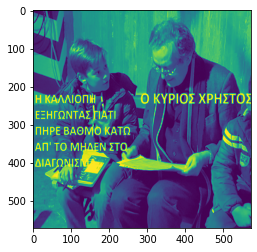

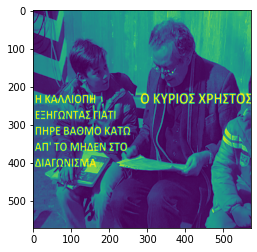

Image size: torch.Size([1, 1, 572, 572])


In [ ]:
import torch 
import torchvision.transforms.functional as fn
from PIL import Image
import matplotlib.pyplot as plt


img = Image.open("image.png")
img = fn.resize(img,size=[572,572])

img = Image.Image.split(img)
for i in range(len(img)):
  plt.imshow(img[i-1])
  plt.show()


convert_tensor = transforms.ToTensor()

img = convert_tensor(img[0])
img = img[None,:]



In [ ]:
import torch
from torch import nn
from torchvision import transforms


class Block(nn.Module):
    def __init__(self,in_ch,out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
            
    #conv->reLU->conv->reLU    
    def forward(self,x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))
    

    
    

In [ ]:
enc_block = Block(1,64)
enc_block(img).shape

X shape torch.Size([1, 1, 572, 572])


torch.Size([1, 64, 568, 568])

In [ ]:
class Encoder(nn.Module):
  def __init__(self,chs=(3,64,128,256,512,1024)):
    super().__init__()
    #loop through the channels and make a list of blocks
    self.enc_blocks = nn.ModuleList([Block(chs[i],chs[i+1]) for i in range(len(chs)-1)])
    #preform maxPool
    self.pool = nn.MaxPool2d(2)


  def forward(self,x):
    features = []
    for block in self.enc_blocks:
      x = block(x)
      features.append(x)
      x = self.pool(x)
    return features 



    

In [ ]:
encoder = Encoder()
# input image
x    = torch.randn(1, 3, 572, 572)
ftrs = encoder(x)
for ftr in ftrs: print(ftr.shape)

torch.Size([1, 64, 568, 568])
torch.Size([1, 128, 280, 280])
torch.Size([1, 256, 136, 136])
torch.Size([1, 512, 64, 64])
torch.Size([1, 1024, 28, 28])


## Decoder

The decoder(right part) consists of upscaling parts by 2x2 convolutions that halves # of features and 2 3x3 convolutions folloewd by a ReLU activation. Cropping is necessary due to the loss of border pixels in every convolution

In [ ]:
import torchvision 

class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

In [ ]:
decoder = Decoder()
x = torch.rand(1,1024,28,28) 
#print(type(ftr))
decoder(x, ftrs[::-1][1:]).shape




torch.Size([1, 64, 388, 388])

In [ ]:
class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1, retain_dim=False, out_sz=(572,572)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

In [ ]:
unet = UNet()
img = Image.open("image.png")
img = fn.resize(img,size=[572,572])
convert_tensor = transforms.ToTensor()
img = convert_tensor(img)
img = img[None,:]
print(img.shape)
x = torch.rand(1,3,572,572)
unet(img).shape

plt.imgshow(unet(img))
plt.show()

torch.Size([1, 4, 572, 572])


RuntimeError: ignored

In [ ]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
    
    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        #List of ConvTranspose2d operations 
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1, retain_dim=False, out_sz=(572,572)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

In [ ]:
unet = UNet()
x    = torch.randn(1, 3, 572, 572)
unet(x).shape

torch.Size([1, 1, 388, 388])